# Introduction
A company offers housing loans to low-income people. Since traditional risk scores do not have
sufficient coverage to correctly assess these potential customers, it was decided to build a new
one using alternative data sources. The objective is to be able to predict the probability of default
for people with no previous credit history.

## Mission
* Develop a credit score to assess whether new clients will be good or bad payers.
* Present the work done (algorithms, techniques, metrics) and possible future improvements.
* Justify the assessment metrics from commercial and technical points of view.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score 
import lightgbm as lgb

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Data Preparation

We will start with the *application_train.csv* table as our base.

In [2]:
train = pd.read_csv("credit-default-risk/application_train.csv")
train.columns= train.columns.str.lower()
train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploratory Data Analysis

What is the percentage of clients that defaulted?

In [3]:
train.target.mean()

0.08072881945686496

In [4]:
train.shape

(307511, 122)

In [5]:
train.sk_id_curr.value_counts().head()

100303    1
131861    1
158488    1
156441    1
160539    1
Name: sk_id_curr, dtype: int64

We see that `sk_id_curr` is a unique identifier. Thus, it will be helpful to merge the main table with others with ease.

#### What is the distribution of some features when grouped by the target?

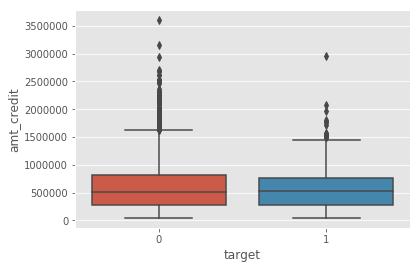

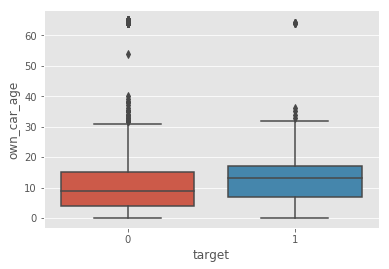

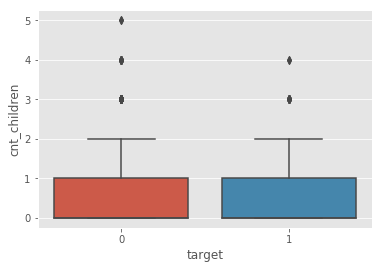

In [6]:
important_feats = ["amt_credit", 'own_car_age', 'cnt_children']

plt.style.use('ggplot')

# A sample is generated to avoid the abundance of outlier candidates.
train_red = train.sample(10000, random_state=42)

for var in important_feats:
    sns.boxplot(x='target', y=var, data=train_red)
    plt.show()

In [7]:
train.groupby('target').amt_income_total.median()

target
0    148500.0
1    135000.0
Name: amt_income_total, dtype: float64

In [8]:
train.groupby('target').region_rating_client.mean() 

target
0    2.043578
1    2.153635
Name: region_rating_client, dtype: float64

These are among the variables that will be used for modeling that come from the main table. For other tables, we will group the data and, in the case several months of information are available, we will keep only the most recent data. THis is due to the limitations of the computer used for data procesing.

#### Helper function

To create synthetic variables, a function is created. This will calculate the mean, max, sum, etc. from the installments, loans, etc, and will merge them with the main table.

In [9]:
def derivate_vars(table, feats):
    group = table.groupby("sk_id_curr")[feats]

    sum_tab = group.sum()
    sum_tab.columns = ["sum_" + x for x in sum_tab.columns]

    max_tab = group.max()
    max_tab.columns = ["max_" + x for x in max_tab.columns]

    mean_tab = group.mean()
    mean_tab.columns = ["mean_" + x for x in mean_tab.columns]

    grouped = pd.concat([sum_tab, max_tab, mean_tab], axis=1).reset_index()

    train_merged = train.merge(grouped, on = "sk_id_curr", how="left")
    
    tab_columns = grouped.columns.tolist()
    
    return train_merged, tab_columns

### Bureau data

* All client's previous credits provided by other financial institutions that were reported to
Credit Bureau (for clients who have a loan in our sample).
* For every loan in our sample, there are as many rows as number of credits the client
had in Credit Bureau before the application date.

In [10]:
bureau = pd.read_csv("credit-default-risk/bureau.csv")
bureau.columns= bureau.columns.str.lower()
bureau.head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [11]:
bureau.sk_id_curr.value_counts().head()

120860    116
169704     94
318065     78
251643     61
425396     60
Name: sk_id_curr, dtype: int64

The _Bureau_ table has more than one record per loan, as expected. Thus, to use it, it will be necesary to group the information beforehand.

In [12]:
# The credits are concentrated on mainly two types: Consumer and Credit card
(bureau.credit_type.value_counts()/len(bureau)).head(6)

Consumer credit                  0.729197
Credit card                      0.234321
Car loan                         0.016132
Mortgage                         0.010715
Microloan                        0.007232
Loan for business development    0.001151
Name: credit_type, dtype: float64

In [13]:
# Feature transformation
bureau["consumer_credit"] = (bureau.credit_type == "Consumer credit") + 0
bureau["credit_card"] = (bureau.credit_type == "Credit card") + 0

bureau["credit_active"] = bureau["credit_active"].map({"Closed": 0, "Active": 1})

In [14]:
feats_to_group = ["credit_active", "days_credit", "credit_day_overdue", "amt_credit_sum", "amt_credit_sum_overdue", "days_credit_update", "consumer_credit", "credit_card"]

result = derivate_vars(bureau, feats_to_group)

train = result[0]
bureau_cols = result[1]
bureau_cols.remove("sk_id_curr")

# To save space, the used tables are changed to empty lists. 
bureau, result = [], []

### Bureau Balance

* Monthly balances of previous credits in Credit Bureau.
* This table has one row for each month of history of every previous credit reported to
Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * #
of months where we have some history observable for the previous credits) rows.

In [15]:
bureau_balance = pd.read_csv("credit-default-risk/bureau_balance.csv")
bureau_balance.columns= bureau_balance.columns.str.lower()
bureau_balance.head()

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [16]:
# Similar information is already included, so this table won't be used.
bureau_balance = []

### POS_CASH_balance

* Monthly balance snapshots of previous POS (point of sales) and cash loans that the
applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home
Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table
has (#loans in sample * # of relative previous credits * # of months in which we have
some history observable for the previous credits) rows.

In [17]:
POS_CASH_balance = pd.read_csv("credit-default-risk/POS_CASH_balance.csv")
POS_CASH_balance.columns= POS_CASH_balance.columns.str.lower()
POS_CASH_balance.head()

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [18]:
# First, we obtain the latest available information per previous loan.

POS_CASH_balance.sort_values(["sk_id_prev", "cnt_instalment_future"], ascending = True, inplace=True)
pos_reduced = POS_CASH_balance.groupby("sk_id_prev").head(1)
pos_reduced.head()

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
45995,1000001,158271,-8,2.0,0.0,Completed,0,0
2792302,1000002,101962,-50,4.0,0.0,Completed,0,0
7085917,1000003,252457,-1,12.0,9.0,Active,0,0
4078063,1000004,260094,-22,7.0,0.0,Completed,0,0
7852623,1000005,176456,-46,10.0,0.0,Completed,0,0


In [19]:
feats_to_group = ["cnt_instalment", "cnt_instalment_future"]

result = derivate_vars(pos_reduced, feats_to_group)

train = result[0]
pos_cols = result[1]
pos_cols.remove("sk_id_curr")

# Used tables are changed to save space.
POS_CASH_balance, pos_reduced, result = [], [], []

### Credit Card Balance

* Monthly balance snapshots of previous credit cards that the applicant has with Home
Credit.
* This table has one row for each month of history of every previous credit in Home
Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table
has (#loans in sample * # of relative previous credit cards * # of months where we
have some history observable for the previous credit card) rows.

In [20]:
ccb = pd.read_csv("credit-default-risk/credit_card_balance.csv")
ccb.columns= ccb.columns.str.lower()
ccb.head()

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [21]:
# First, we obtain the latest available information per previous loan.

ccb.sort_values(["sk_id_prev", "months_balance"], ascending = True, inplace=True)
ccb_reduced = ccb.groupby("sk_id_prev").head(1)
ccb_reduced.head()

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
1375415,1000018,394447,-6,38879.145,45000,13500.0,51042.645,0.0,37542.645,0.0,...,37542.645,37542.645,3.0,15,0.0,12.0,0.0,Active,0,0
1884819,1000030,361282,-8,0.000,45000,NaN,0.000,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
1675650,1000031,131335,-16,0.000,45000,NaN,0.000,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
686129,1000035,436351,-6,0.000,225000,NaN,0.000,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
2002682,1000077,181153,-12,0.000,45000,NaN,0.000,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [22]:
feats_to_group = ["amt_balance", "amt_credit_limit_actual", "amt_inst_min_regularity", "cnt_drawings_atm_current"]

# Information with similar variable names is included on other tables; they will be renamed to include "cc" (Credit Card)
rename_cols = ["cc_" + x for x in feats_to_group]

ccb_reduced.rename(columns=dict(zip(feats_to_group, rename_cols)), inplace=True)

result = derivate_vars(ccb_reduced, rename_cols)

train = result[0]
ccb_cols = result[1]
ccb_cols.remove("sk_id_curr")

# Used tables are changed in order to save space.
ccb, ccb_reduced, result = [], [], []

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Previous application

* All previous applications for Home Credit loans of clients who have loans in our
sample.
* There is one row for each previous application related to loans in our data sample.

In [23]:
previous = pd.read_csv("credit-default-risk/previous_application.csv")
previous.columns= previous.columns.str.lower()
previous.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


*Name* features are analyzed, to see which values are the more common and that deserve the creation of dummy features.

In [24]:
previous.name_contract_type.value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: name_contract_type, dtype: int64

In [25]:
previous.name_contract_status.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: name_contract_status, dtype: int64

In [26]:
previous.cnt_payment.value_counts().head()

12.0    323049
6.0     190461
0.0     144985
10.0    141851
24.0    137764
Name: cnt_payment, dtype: int64

In [27]:
previous["previous_cash"] = (previous.name_contract_type == "Cash loans") + 0
previous["previous_consumer"] = (previous.name_contract_type == "Consumer loans") + 0
previous["previous_revolving"] = (previous.name_contract_type == "Revolving loans") + 0
previous["previous_approved"] = (previous.name_contract_status == "Approved") + 0
previous["previous_canceled"] = (previous.name_contract_status == "Canceled") + 0
previous["previous_refused"] = (previous.name_contract_status == "Refused") + 0

previous.rename(columns={"amt_annuity": "previous_amt_annuity",
                         "days_decision": "previous_days_decision",
                         "cnt_payment": "previous_cnt_payment"}, inplace=True)

In [28]:
feats_to_group = ["previous_cash", "previous_consumer", "previous_revolving", "previous_approved", "previous_canceled", "previous_refused", "previous_amt_annuity", "previous_days_decision", "previous_cnt_payment"]

result = derivate_vars(previous, feats_to_group)

train = result[0]
previous_cols = result[1]
previous, result = [], []

previous_cols.remove("sk_id_curr")

### Installments payments

* Repayment history for the previously disbursed credits in Home Credit related to the
loans in our sample.
* There is a) one row for every payment that was made plus b) one row each for missed
payment.
* One row is equivalent to one payment of one installment OR one installment
corresponding to one payment of one previous Home Credit credit related to loans in
our sample.

In [29]:
installments = pd.read_csv("credit-default-risk/installments_payments.csv")
installments.columns= installments.columns.str.lower()
installments.head()

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [30]:
# The difference between what should have beeen paid, and how much was actually paid in the past.

installments["unpaid"] = installments["amt_instalment"]	- installments["amt_payment"]

In [31]:
feats_to_group = ["amt_instalment", "amt_payment", "unpaid"]

result = derivate_vars(installments, feats_to_group)

train = result[0]
inst_cols = result[1]
installments, result = [], []

inst_cols.remove("sk_id_curr")

## More Feature Engineering

In [32]:
# Flags are changed into numerical values

mapper = {"Y":1, "N":0}

train["flag_own_car"] = train["flag_own_car"].map(mapper)
train["flag_own_realty"] = train["flag_own_realty"].map(mapper)

In [33]:
# The amt_req_credit... features were excluding the previous feature, so the values are added together.

train["amt_req_credit_bureau_day_full"] = train["amt_req_credit_bureau_day"] + train["amt_req_credit_bureau_hour"]
train["amt_req_credit_bureau_week_full"] = train["amt_req_credit_bureau_week"] + train["amt_req_credit_bureau_day_full"]
train["amt_req_credit_bureau_mon_full"] = train["amt_req_credit_bureau_mon"] + train["amt_req_credit_bureau_week_full"]

In [34]:
# We create some features based on the "name..." columns

train["came_alone"] = (train.name_type_suite == "Unaccompanied") + 0
train["income_working"] = (train.name_income_type == "Working") + 0
train["income_commercial"] = (train.name_income_type == "Commercial associate") + 0
train["income_pensioner"] = (train.name_income_type == "Pensioner") + 0
train["family_married"] = (train.name_family_status == "Married") + 0
train["family_single"] = (train.name_family_status == "Single / not married") + 0
train["housing_own"] = (train.name_housing_type == "House / apartment") + 0

## Model Training

For modeling, we won't be using all of the available features: we will leave only the synthetic variables, which were created based only on the features which were deemed to include valuable information about the client. In addition, only some of the features from the original table have been included: this is due to the presence of valuable data (as deemed by the modeler), or if they are demographic data (this is not included due to ethical concerns).

In [35]:
pred_feat = ['flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'days_employed',
             'amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day_full', 'amt_req_credit_bureau_week_full', 'amt_req_credit_bureau_mon_full',
             'own_car_age', 'flag_mobil', 'flag_emp_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'region_rating_client',
             'came_alone', 'income_working', 'income_commercial', 'income_pensioner', 'family_married', 'family_single', 'housing_own']

pred_feat = pred_feat + bureau_cols + pos_cols + previous_cols + ccb_cols + inst_cols
len(pred_feat)

104

Pairs of highly correlated features exist: some will be eliminated, since they contain rendundant information.

In [36]:
corre = train[pred_feat].corr()
np.fill_diagonal(corre.values, 0)

corre = pd.melt(corre.reset_index(), id_vars='index')
corre.columns = ["feat1", "feat2", "correlation"]

thres = 0.95
hi_corre = corre[corre.correlation > thres]
hi_corre.sort_values("correlation", inplace=True)
hi_corre.reset_index(drop=True, inplace=True)

for var in hi_corre.feat1[np.arange(0, len(hi_corre)-1, 2)]:
    try:
        pred_feat.remove(var)
    except:
        print(var)

max_cc_cnt_drawings_atm_current
sum_cc_amt_balance


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
len(pred_feat)

86

Data is divided into training and testing sets. Since the data is too large, and a personal computer is being used for data processing, only 30% will be used for modeling, and the rest will be separated for testing.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(train[pred_feat].fillna(0), 
                                                  train["target"], train_size=0.3, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [39]:
import warnings
warnings.filterwarnings("ignore")

Two models will be fitted into the data: a Logistic Regression, and a LightGBM. Since the target is unbalanced, AUC will be used as the main metric.

### Logistic Regression

A logistic regression is fitted first, using the *LogisticRegressionCV* function from sci-kit learn. 5-fold cross validation will be used to select the "best" parameters; specifically, the penalization C. This is important, since l-1 (Lasso Regression) is being used to select the best set of features.

In [40]:
#reg = LogisticRegressionCV(penalty="l1", solver="liblinear", class_weight="balanced")
reg = LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", C=0.005)
reg.fit(X_train, y_train)

LogisticRegression(C=0.005, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
print("Train AUC Score:")
roc_auc_score(y_train, reg.predict_proba(X_train)[:, 1])

Train AUC Score:


0.6923800110416867

In [42]:
print("Test AUC Score:")
roc_auc_score(y_test, reg.predict_proba(X_test)[:, 1])

Test AUC Score:


0.6892292140763308

In [43]:
feat_importance = pd.DataFrame()
feat_importance["feat"] = pred_feat
feat_importance["coefficient"] = reg.coef_[0]

# We only keep the final set of variables. Since they are not in the same scale, the coefficient is not comparable.
feat_importance[feat_importance.coefficient > 0]

,feat,coefficient
2,cnt_children,2.494870e-02
5,amt_annuity,1.366127e-05
10,own_car_age,5.523069e-03
16,region_rating_client,2.642969e-01
18,income_working,2.208346e-01
24,sum_credit_active,1.489026e-01
25,sum_days_credit,3.959352e-05
27,sum_amt_credit_sum,8.702965e-09
28,sum_amt_credit_sum_overdue,2.992818e-06
34,max_amt_credit_sum,7.230639e-09


In [44]:
reg.intercept_

array([0.])

In [45]:
final_feats_reg = feat_importance[feat_importance.coefficient>0].feat.tolist()
print(len(final_feats_reg))

29


### LightGBM fit

Then, a LightGBM is fitted. Using 5-fold cross validation, the best parameters are tested. This parameters were chosen by the modeler, to try to maximize the predictive value while avoiding overfit. *reg_alpha* is used to do feature selection. 

In [46]:
cv_params = {"num_iterations":[50, 100],
            "max_depth":[3, 5],
            "learning_rate":[0.1, 0.2],
            "num_leaves":[20, 25],
             "reg_alpha":[100, 200],
            "metric":["auc"]
}

estimator = lgb.LGBMClassifier(objective="binary",
                               class_weight="balanced", 
                               metric="auc")

gridsearch = GridSearchCV(estimator, cv_params, cv=5)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_iterations': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2], 'num_leaves': [20, 25], 'reg_alpha': [100, 200], 'metric': ['auc']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
gridsearch.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'metric': 'auc',
 'num_iterations': 100,
 'num_leaves': 25,
 'reg_alpha': 100}

In [48]:
params = gridsearch.best_params_
model = lgb.LGBMClassifier(objective="binary", 
                            max_depth = params["max_depth"], 
                            num_iterations = params["num_iterations"],
                            learning_rate = params["learning_rate"],
                            num_leaves = params["num_leaves"],
                            reg_alpha= params["reg_alpha"],
                            reg_lambda=50,
                            class_weight="balanced",
                            metric="auc")

model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.2,
        max_depth=5, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_iterations=100, num_leaves=25, objective='binary',
        random_state=None, reg_alpha=100, reg_lambda=50, silent='warn',
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [49]:
print("Train AUC Score:")
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

Train AUC Score:


0.7761462717908488

In [50]:
print("Test AUC Score:")
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

Test AUC Score:


0.7117027983578652

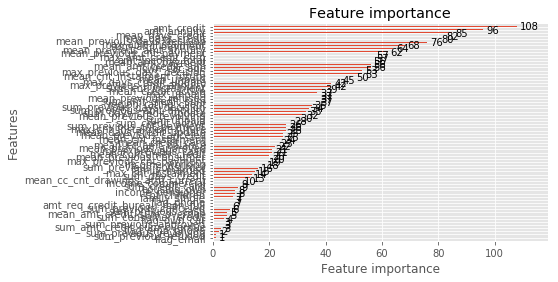

In [51]:
lgb.plot_importance(model)
plt.show()

In [52]:
importances = pd.DataFrame([])
importances['feat'] = X_train.columns
importances['importance'] = model.feature_importances_
importances.sort_values("importance", inplace=True, ascending=False)

importances[importances["importance"] > 0]

,feat,importance
4,amt_credit,108
5,amt_annuity,96
39,mean_days_credit,85
33,max_days_credit,82
76,mean_previous_days_decision,80
82,max_amt_instalment,76
80,sum_amt_payment,68
75,mean_previous_amt_annuity,64
77,mean_previous_cnt_payment,62
34,max_amt_credit_sum,57


In [53]:
final_feats_lgb = model.feature_importances_ > 0
final_feats_lgb.sum()

68

In [54]:
len(model.feature_importances_)

86

## Model Evaluation

### Correlation of Final Features

From the pool of final features, there do not seem to be pair of highly correlated features. Therefore, there does not seem to be rendundant information included, and the final feature importances are not diluted. 

In [55]:
corre = X_train.loc[:, final_feats_lgb].corr()

np.fill_diagonal(corre.values, 0)
corre.style.highlight_max(axis=0)

,flag_own_car,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_req_credit_bureau_mon_full,own_car_age,flag_emp_phone,flag_phone,flag_email,region_rating_client,income_working,income_commercial,income_pensioner,family_married,family_single,housing_own,sum_credit_active,sum_days_credit,sum_amt_credit_sum,sum_amt_credit_sum_overdue,sum_days_credit_update,sum_consumer_credit,sum_credit_card,max_days_credit,max_amt_credit_sum,max_days_credit_update,mean_credit_active,mean_days_credit,mean_amt_credit_sum,mean_amt_credit_sum_overdue,mean_days_credit_update,mean_consumer_credit,mean_credit_card,sum_cnt_instalment,max_cnt_instalment,max_cnt_instalment_future,mean_cnt_instalment,mean_cnt_instalment_future,sum_previous_cash,sum_previous_consumer,sum_previous_revolving,sum_previous_approved,sum_previous_canceled,sum_previous_refused,sum_previous_amt_annuity,sum_previous_days_decision,sum_previous_cnt_payment,max_previous_amt_annuity,max_previous_days_decision,max_previous_cnt_payment,mean_previous_cash,mean_previous_consumer,mean_previous_revolving,mean_previous_approved,mean_previous_canceled,mean_previous_refused,mean_previous_amt_annuity,mean_previous_days_decision,mean_previous_cnt_payment,mean_cc_amt_balance,mean_cc_cnt_drawings_atm_current,sum_amt_payment,sum_unpaid,max_amt_instalment,max_unpaid,mean_amt_payment,mean_unpaid
flag_own_car,0,0.0994557,0.19764,0.115153,0.140964,0.0271462,0.634676,0.151942,-0.00848477,0.0288438,-0.0244815,0.0664891,0.0587478,-0.151918,0.150264,-0.0624564,0.0170052,0.0447177,-0.0554721,0.14202,-0.00381798,-0.0339964,0.0281626,0.0285267,-0.00767719,0.141724,0.0229889,0.0199466,-0.0465508,0.110274,-0.00370677,-0.0110889,-0.00821021,-0.00309501,-0.0391792,-0.0572254,-0.0667959,-0.0627458,-0.0616515,-0.042429,0.0751087,-0.0171987,0.00265755,-0.034248,0.0100485,0.0429873,-0.023297,-0.0113914,0.0757932,-0.000220488,-0.0159459,-0.051511,0.0461401,-0.0192431,-0.010832,-0.0352726,0.0191306,0.0661261,-0.0242474,-0.0260366,0.00103933,-0.00424169,0.0284953,-0.00489652,0.0392174,0.0221708,0.0485919,-0.00950627
cnt_children,0.0994557,0,0.0272231,0.00295645,0.0233676,-0.0105954,0.0671161,0.242576,-0.0324409,0.0222999,0.0245188,0.135294,0.0286451,-0.242641,0.172215,-0.139998,-0.0218494,0.0169027,-0.000734663,0.03552,0.00198168,0.000345132,0.00307044,0.00645343,0.00946841,0.0549827,0.0122383,0.0236438,0.00332227,0.035194,0.000988932,0.00556248,0.00201219,0.00725758,-0.0496218,-0.0577396,-0.0523973,-0.0465859,-0.042242,-0.0734707,0.072687,-0.00559453,-0.00430836,-0.0424993,-0.0216464,-0.0404138,0.00986081,-0.049433,-0.0249865,-0.00375307,-0.0474249,-0.081412,0.0923204,-0.00331341,0.041631,-0.0344665,-0.0080983,-0.0357117,-0.0178693,-0.0472448,0.00232297,0.00542364,-0.0509379,0.0140557,-0.0160206,-0.0112311,-0.0176123,0.0144357
amt_income_total,0.19764,0.0272231,0,0.371142,0.444656,0.0631981,0.0483307,0.148201,0.00328579,0.0905593,-0.202414,-0.0639779,0.189356,-0.148269,0.0256015,-0.000249821,0.0125296,0.143262,-0.119894,0.332258,-0.0028959,-0.0738388,0.0700621,0.144508,0.00885707,0.306891,0.0451528,0.0575922,-0.0627864,0.238771,-0.00294213,-0.00635746,-0.0429225,0.0800154,0.00502514,-0.00483608,-0.0085551,-0.0269586,-0.0139916,0.0565975,-0.00617085,0.0259533,0.0179756,0.0464505,0.0438664,0.194181,-0.0353101,0.0533612,0.263333,0.0373313,0.0485658,0.045003,-0.0895642,0.00753412,-0.0915667,0.0326915,0.028628,0.269468,0.0307884,0.0257724,0.0395016,0.00784369,0.187031,-0.0385759,0.154054,0.102289,0.170344,-0.0445253
amt_credit,0.115153,0.00295645,0.371142,0,0.771035,0.0512063,0.025347,0.0648172,0.0256285,0.0254148,-0.104147,-0.0545093,0.0957999,-0.0649919,0.145275,-0.0953405,0.0446936,0.0511638,-0.0945558,0.150738,-0.00231365,-0.071689,0.0403411,0.0793303,-0.0336609,0.138316,0.0034139,-0.000320292,-0.0938864,0.112819,-0.000543535,-0.053762,-0.0105605,0.0420984,-0.0317252,-0.0545355,-0.0931523,-0.0637614,-0.100422,-0.0189468,-0.0139396,-0.0364463,-0.00454828,-0.0227779,-0.0403483,0.0983182,-0.0266613,0.0137091,0.166545,-

### Interpretability
We will see how the score is being generated, by evaluating the credit score (risk of defaulting) against the values from the top 5 most important features:

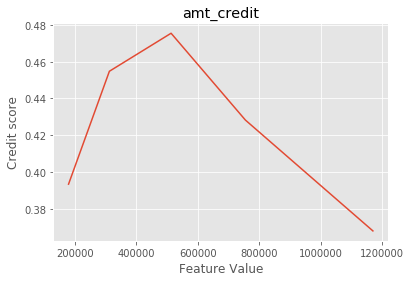

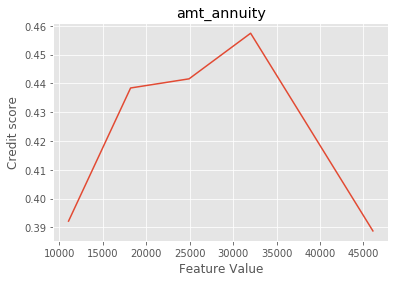

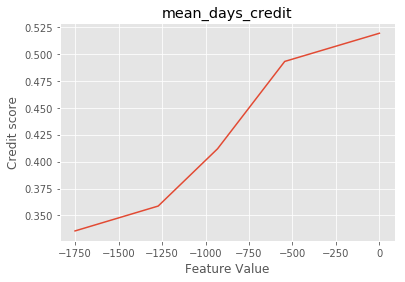

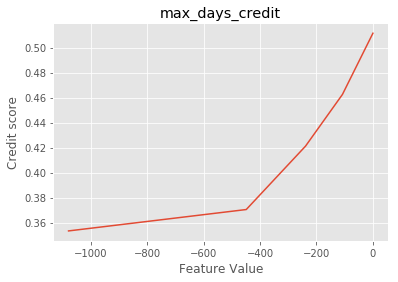

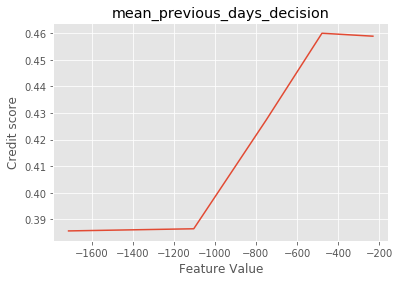

In [56]:
important_feats = importances.feat.tolist()[:5]

to_plot = X_train[pred_feat].copy()
to_plot["score"] = model.predict_proba(to_plot)[:, 1]

for var in important_feats:
    to_plot["bin"] = pd.qcut(to_plot[var], 5, duplicates="drop")
    plot_x = to_plot.groupby("bin")[var].median()
    plot_y = to_plot.groupby("bin")["score"].mean()

    plt.plot(plot_x, plot_y)
    plt.title(var)
    plt.xlabel("Feature Value")
    plt.ylabel("Credit score")
    plt.show()

Thus, we are able to conclude that: 

* Up to 500,000, the higher the amount of the credit, the higher the estimated chances of defaulting. This is reversed after 500,000. 
* The higher the amount of payments from previous loans, the higher the estimated chances of defaulting.
* The higher the amounts left unpaid from previous loan's installments, the higher the estimated chances of defaulting.
* The longer the credit, the higher the chances of defaulting.

## Conclusions

The Chosen model is a LightGBM model with an AUC of 71% on the testing set. Since it is larger than 50%, we can conclude that the model does helps into the ranking the clients with a higher chance of defaulting.

The AUC is similar between the training and testing datasets. Therefore, we may conclude that there is only a small overfit.

Alternatively, a Logistic Regression may be used. Eventhough the ranking capability of the model for this specific problem is slightly lower, it uses a lot less features. Therefore, it may be prefered in the case that there are limited resources for the scoring, or if there are problems with some of the features used on the LightGBM and not present on the Logistic Regression.

Future improvements can be done on this particular problem. To begin, the data is from less than a year, and date information was limited. Thus, we could not observe if there were seasonal patterns or a growing/reducing defaulting trend.

Also, some other algorithms could have been fitted and tested on the data, to determine if they were a better match. Logistic Regression was used since it was a simple, yet effective model, while LightGBM was used since experience has shown to it having better predictive capabilities and faster training/prediction than other Tree-based models, such as Random Forests and XGBoost. However, those other tree-based models, as well as SVM, Neural Networks, ensemble models, etc. Could be tested in the future.

In addition, data could be processed better. Since computing power was limited, the only data used was the most recent available. However data could have also been processed to include data from the last three/six months, etc. 

Finally, as always, new data could have been obtained from other sources, and they could have increased the prediction capability.